In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from IPython.display import display, Math, HTML
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_context('talk')

# Introduction

Generate dummy data of daily spending in IDR.

In [3]:
np.random.seed(144)

df_spend = pd.DataFrame(
            data={
                'date_column': pd.date_range(
                    start='2016-01-01',
                    end='2017-06-30',
                    freq='D'
                ),
                'spending': np.random.choice(np.arange(0,5), size=547) * np.random.choice([5e3, 1e4]) + np.random.choice([5e2,1e3,3e3])
            }
        )

In [4]:
cpt = {
    '2016-04-20': 1.5,
    '2016-07-29': 2,
    '2016-12-11': 1,
    '2017-05-19': 1
}

In [5]:
for change, multiplier in cpt.items():
    mask = (df_spend['date_column'] >= pd.to_datetime(change))
    df_spend.loc[mask, 'spending'] = np.round(
        df_spend[mask]['spending'] * (1+np.random.choice(np.arange(0,multiplier,0.1))),
        0
    )

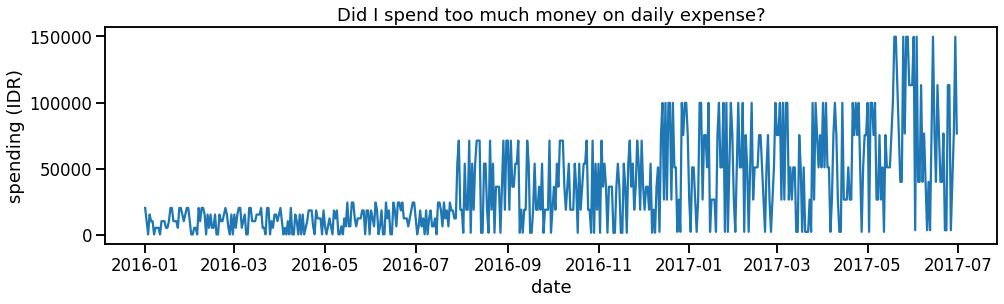

In [6]:
f, ax = plt.subplots(figsize=(16,4))

sns.lineplot(
    data=df_spend,
    x='date_column',
    y='spending',
    ax=ax
)

plt.title("Did I spend too much money on daily expense?")
plt.xlabel("date")
plt.ylabel("spending (IDR)")
plt.show();

# Control charts

In [7]:
def calculate_control_limit(data, sigma=2):
    std_dev = np.std(data) * sigma
    upper_bound = np.mean(data) + std_dev
    lower_bound = np.max(
        [
            0,
            np.mean(data) - std_dev
        ]
    )
    return upper_bound, lower_bound

In [8]:
import matplotlib.dates as mdates

def visualize_control_chart(x_axis, y_axis, upper_bound, lower_bound):
    f, ax = plt.subplots(figsize=(12,4))
    
    sns.lineplot(
        x=x_axis,
        y=y_axis,
        ax=ax,
        label='observation'
    )
    
    plt.axhline(
        lower_bound,
        label='lower control limit = {:,.2f}'.format(np.round(lower_bound)),
        linestyle='--',
        color='red'
    )

    plt.axhline(
        upper_bound,
        label='upper control limit =  {:,.2f}'.format(upper_bound),
        linestyle='--',
        color='red'
    )

    # format the coords message box
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    f.autofmt_xdate()

    plt.legend(bbox_to_anchor=[1.05,1])
    plt.xlabel("")
    plt.ylabel("spending (IDR)")
    plt.show();

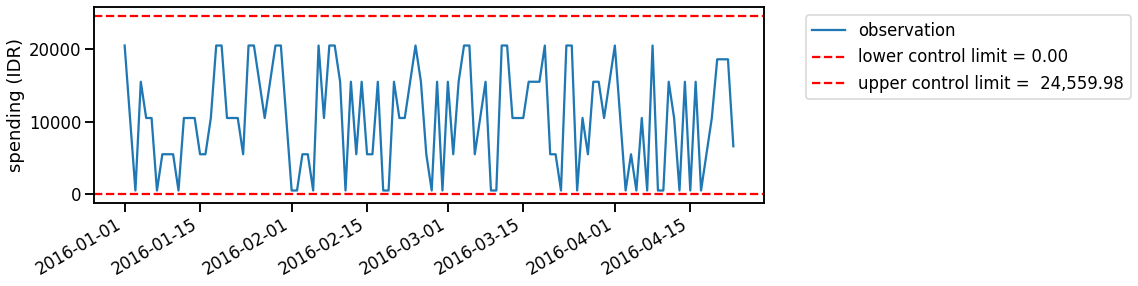

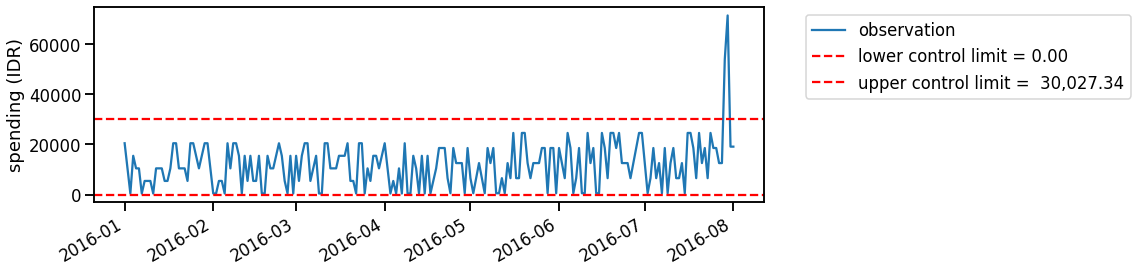

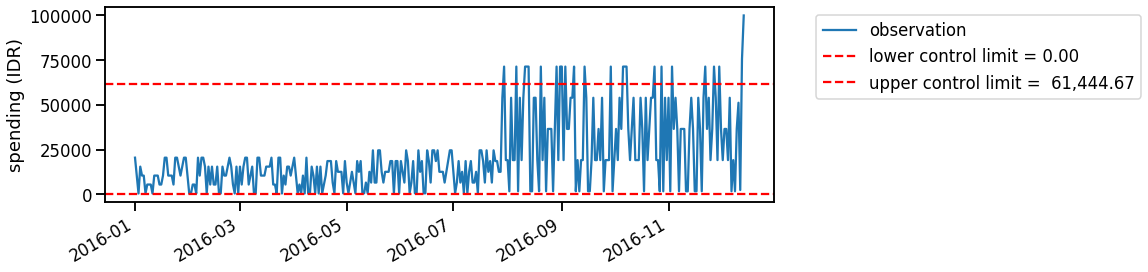

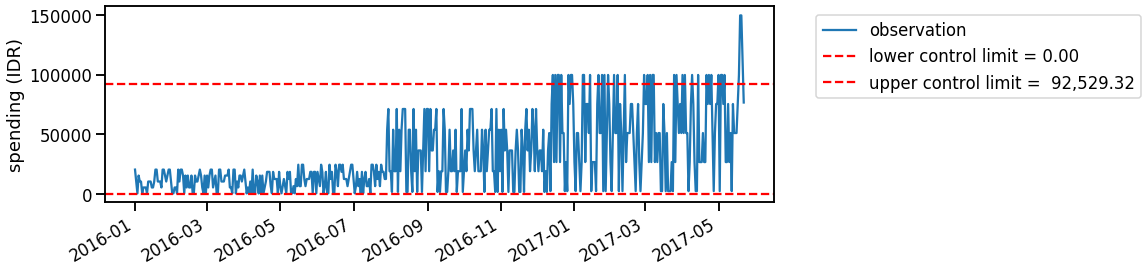

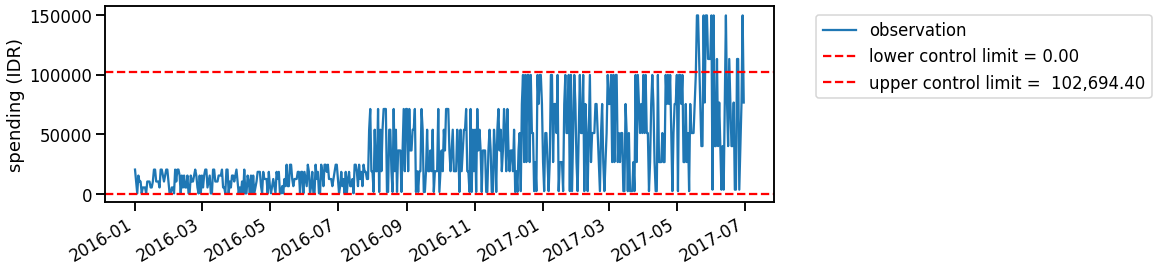

In [9]:
cpt_list = list(cpt.keys())
cpt_list.append('2017-06-30')

for change in cpt_list:
    mask = (df_spend['date_column'] <= pd.to_datetime(change) + np.timedelta64(3,'D'))
    
    obs = df_spend[mask].copy()
    upper_limit, lower_limit = calculate_control_limit(obs['spending'])
    
    visualize_control_chart(
        obs['date_column'],
        obs['spending'],
        upper_limit,
        lower_limit
    )

# CUSUM approach

In [10]:
def calculate_cusum_residuals(df, observation_column=0):
    mu = df[observation_column].mean()
#     df = pd.concat(
#             [
#                 pd.DataFrame(data=[0]),
#                 df
#             ]
#         ).reset_index().drop(labels=['index'], axis=1)
    df = df.shift(1)
    df['residual'] = df[observation_column] - mu
    df.loc[(df.index == 0), 'residual'] = 0
    df['residual_cumsum'] = df['residual'].cumsum()
    return df

In [11]:
df_spend = calculate_cusum_residuals(df_spend, observation_column='spending')

In [12]:
df_spend.head()

,date_column,spending,residual,residual_cumsum
0,NaT,NaN,0.000000,0.000000
1,2016-01-01,20500.0,-14227.104205,-14227.104205
2,2016-01-02,10500.0,-24227.104205,-38454.208410
3,2016-01-03,500.0,-34227.104205,-72681.312614
4,2016-01-04,15500.0,-19227.104205,-91908.416819


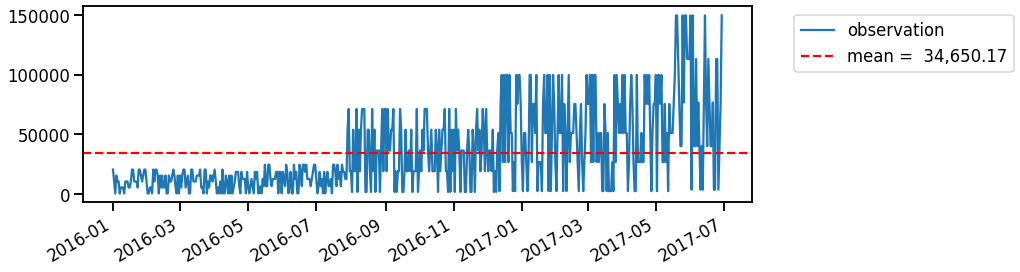

In [13]:
f, ax = plt.subplots(figsize=(12,4))

plt.plot(
    df_spend['date_column'],
    df_spend['spending'],
    label='observation'
);

plt.axhline(
    y=np.mean(df_spend['spending']),
    label='mean =  {:,.2f}'.format(np.mean(df_spend['spending'])),
    linestyle='--',
    color='red'
)

plt.legend(bbox_to_anchor=[1.05,1])
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
f.autofmt_xdate()

plt.show();

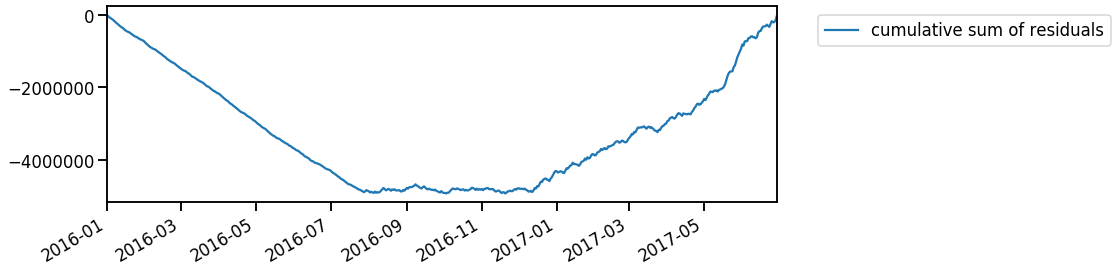

In [14]:
f, ax = plt.subplots(figsize=(12,4))

df_spend.plot(
    x='date_column',
    y='residual_cumsum',
    kind='line',
    ax=ax,
    label='cumulative sum of residuals'
);

plt.legend(bbox_to_anchor=[1.05,1])
plt.xlabel('')
plt.show();

## How confident are we, that the change really exists?

CUSUM estimator is a **frequentist method**, we gain confidence interval by collecting data and observing the results in the **long run**. Since we have limited observations, we can do **sampling without replacement** (in other words, we randomly reorder the observations): 
1. determine number of iteration $N$
2. for each iteration:
    - take random sample without replacement from the observations $X^0_{1}, X^0_{2}, ..., X^0_{n}$, where $n$ = number of observations
    - calculate the sample's cumulative sum of residuals ($S^0$): $S^0_{1}, S^0_{2}, ..., S^0_{n}$
    - calculate the difference between maximum and minimum residuals in each bootstrap $$S^0_{\text{diff}} = S^0_{max} - S^0_{min}$$
    - if $S^0_{\text{diff}} < S_{\text{diff}}$, it means the result from the sample is consistent with actual observations
    
Thus, the confidence level can be calculated: $$\text{confidence level} (\%) = 100 * \frac{X}{N}$$
where $X$ represents number of iteration which has $S^0_{\text{diff}} < S_{\text{diff}}$

In [15]:
def calculate_residual_difference(df):
    ## calculate difference between maximum and minimum cumsum residuals
    resid_max = df['residual_cumsum'].max()
    resid_min = df['residual_cumsum'].min()

    resid_diff = resid_max - resid_min
    return resid_diff

In [16]:
resid_diff = calculate_residual_difference(df_spend)
print("Observed residual difference: {:,.2f}".format(resid_diff))

Observed residual difference: 4,922,827.86


In [17]:
N = 1000
X = 0 ## occurrence when sample residual difference < observed residual difference

for i in np.arange(0,N):
    _sample = pd.DataFrame(
        np.random.choice(df_spend['spending'], size=df_spend.shape[0], replace=False)
    )
    _sample = calculate_cusum_residuals(_sample)
    _sample_resid_diff = calculate_residual_difference(_sample)
    
    if _sample_resid_diff < resid_diff:
        X += 1

confidence_level = 100 * X / N
print("Confidence level: {:.2f}%".format(confidence_level))

Confidence level: 100.00%


# MSE estimator

Idea:
1. Split the observations into two segments: 
    - segment 1 = $\left\{1, ..., m\right\}$
    - segment 2 = $\left\{m+1, ..., n\right\}$
2. Calculate average value of each segment: $\bar{X}_1$ and $\bar{X}_2$
3. Observe how well the observations fit to the estimated averages: $$MSE = \Sigma_{1}^{m}(x_{i} - \bar{X}_1)^2 + \Sigma_{m+1}^{n}(x_{i} - \bar{X}_2)^2$$
4. Value of **$m$ which minimizes the mean squared error** is the **best estimate of last point before the change occurred**

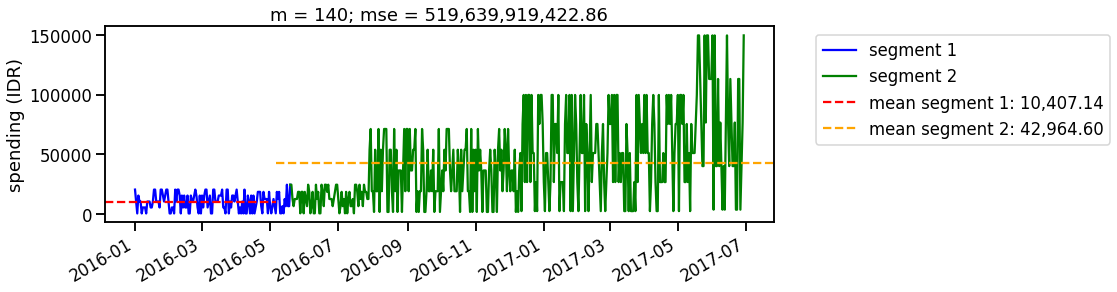

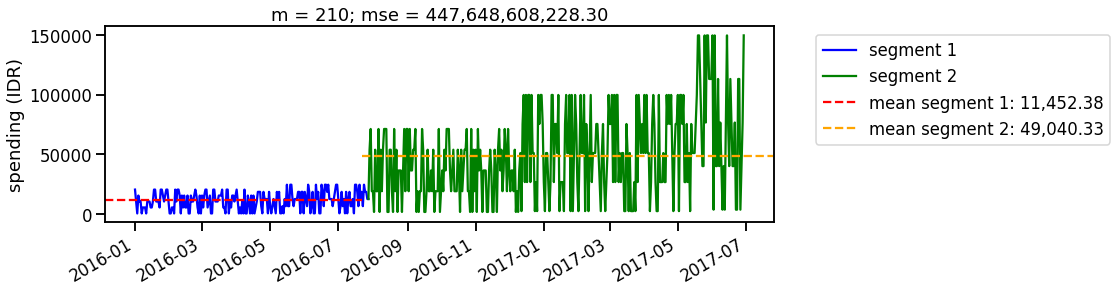

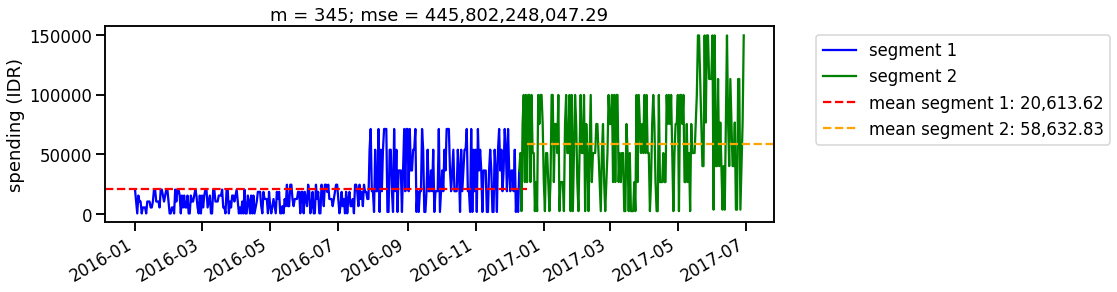

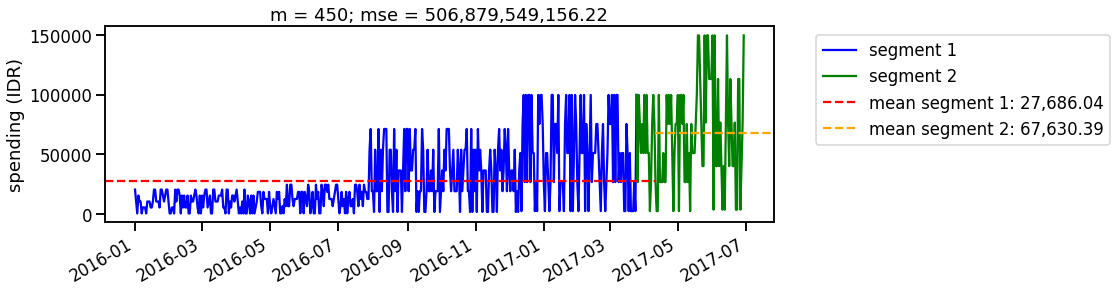

In [18]:
mse_estimator = pd.DataFrame({
    'm': [],
    'mse': []
})

## calculate mse for each m
for i in np.arange(df_spend.shape[0]):
    segment_1 = df_spend.loc[:i]
    segment_2 = df_spend.loc[i:]
    
    mean_segment_1 = segment_1['spending'].mean()
    mean_segment_2 = segment_2['spending'].mean()
    
    mse = np.power((segment_1['spending'] - mean_segment_1),2).sum() + np.power((segment_2['spending'] - mean_segment_2),2).sum()
    mse_estimator = mse_estimator.append(
        pd.DataFrame({
                'm': i,
                'mse': mse
            }, index=[-0])  
    )
    
    if i in [140, 210,  345, 450]:
        f, ax = plt.subplots(figsize=(12,4))
        
        sns.lineplot(
            x=segment_1['date_column'],
            y=segment_1['spending'],
            label='segment 1',
            color='blue'
        )
        
        sns.lineplot(
            x=segment_2['date_column'],
            y=segment_2['spending'],
            label='segment 2',
            color='green'
        )
        
        plt.axhline(
            y=mean_segment_1,
            xmin=segment_1.index.min() / df_spend.shape[0],
            xmax=segment_1.index.max() / df_spend.shape[0],
            linestyle='--',
            color='red',
            label='mean segment 1: {:,.2f}'.format(mean_segment_1)
        )
        
        plt.axhline(
            y=mean_segment_2,
            xmin=segment_2.index.min() / df_spend.shape[0],
            xmax=segment_2.index.max() / df_spend.shape[0],
            linestyle='--',
            color='orange',
            label='mean segment 2: {:,.2f}'.format(mean_segment_2)
        )
        
        ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
        f.autofmt_xdate()
        plt.xlabel('')
        plt.ylabel('spending (IDR)')
        
        plt.legend(bbox_to_anchor=[1.05,1])
        plt.title('m = {}; mse = {:,.2f}'.format(i, mse))
        plt.show();
        
mse_estimator.reset_index(inplace=True)